# Algorithm Hierarchical Clustering M

describe

In [80]:

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np 

class HierarchicalClustering:
    
    def __init__(self, alpha = 1.01, max_iteration = 100):
        ''' '''
        self.alpha = alpha
        self.max_iteration = max_iteration
        
    
    def score(sefl, x):
        ''' '''
    
    
    def fit(self, x):
        ''' '''
        y_ = []
        M =  euclidean_distances(x,x)
        C = []
        size = len(M)
        for i in range(size):
            '''  (set clusters, is active, to join, distance) '''
            C.append([set([i]), 1, -1, 0]) 
        
        delta = 0.
        
        for i in range(self.max_iteration):
            p_min = 100
             
            d = np.min(M[M > 0]) * self.alpha
            if d > delta:
                delta = d
            print(delta)    
            M_ = M - delta
            ''' join clusters '''
            for i in range(size):  
                for j in range(i,size):  
                    if(M[i][j] <= 0 or M_[i][j] > 0): # old
                        continue
                    if i == j:
                        continue 
                    a = i
                    b = j
            
                    if C[i][2] != -1:
                        a = C[i][2]
                    if C[j][2] != -1: 
                        b = C[j][2]
                
                    if(a == b):
                        continue
            
                    C[a][0] = C[a][0].union(C[b][0])  
                    C[b][1] = C[b][1] - 1
                    C[b][2] = a 
                    C[a][1] = 1
            ''' update matrix '''
            M = M_
            y_ = np.zeros(size)
            cl = 0
            for c in C:
                if(c[1] == 1): 
                    for i in c[0]:
                        y_[i] = cl
                    cl = cl + 1
                    
            if len(M[M > 0]) == 0:
                break
                
            neg,pos = [],[]    
            for i in range(size): 
                for j in range(i,size):
                    if(M[i][j] <= 0):
                        neg.append(delta + np.abs(M[i][j]))
                    else:
                        pos.append(M[i][j])    
            print(sum(pos), sum(neg)) 
            if sum(pos) < sum(neg):
                break
        return y_                
        
    def print_name(self):
        print('Hierarchical clustering')
        


In [83]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array([
    [1,1],
    [1,2],
    [2,2],
    [2,1],
    
    #[4,4],
    
    [5,5], 
    [6,6],
    [6,7],
    
    [3.5,7],
    
    # 
    [3.6,7.1],
    [3.7,6.9],
    [3.8,6.9]
    
    
])

def draw(x, y):
    k = 2
    U,s,vh = np.linalg.svd(x) 
    k = min(k, len(s))

    x1 = np.dot(U[:,0:k] * s[0:k], vh[0:k]) 

    plt.rcParams["figure.figsize"] = (12,12)
    plt.scatter(x1[:,0], x1[:,1], c=y)

   

Hierarchical clustering
0.10999999999998906
(204.28933802397418, 2.539999999999748)
0.10999999999998906
(198.4279166677375, 4.048578643762263)
0.10999999999998906
(192.8716325937465, 6.192294569770496)
0.737000000000036
(157.0936325937448, 33.40029456977211)
0.737000000000036
(125.834991906624, 52.994653882653836)
0.737000000000036
(97.50632710129179, 81.41498907732439)
0.737000000000036
(76.61966894123485, 110.64433091726988)
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


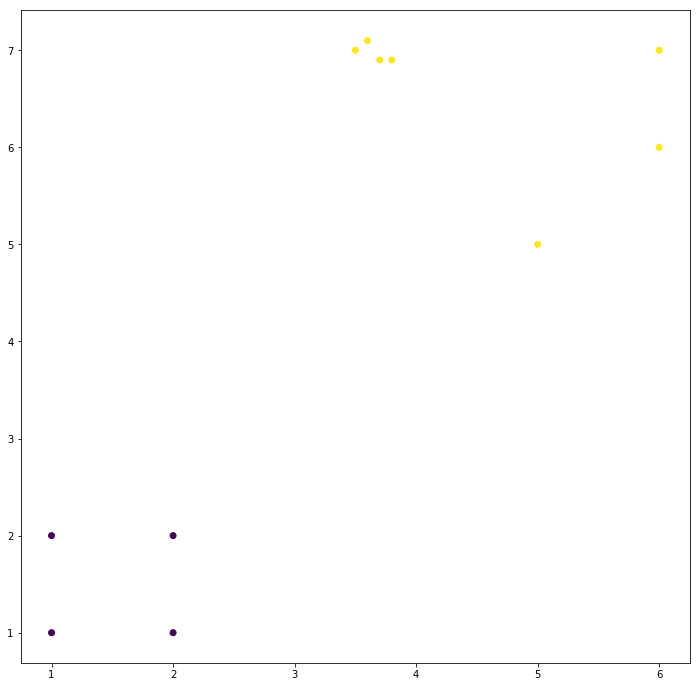

In [84]:
hc = HierarchicalClustering(alpha = 1.1, max_iteration=8)
hc.print_name()
Y_ = hc.fit(x)
print(Y_)
draw(x, Y_)